# Covid 19 - Mexico Status

## Introduction

The Covid 19 pandemic is the largest human and health crisis in the last 90 years. As it is a new virus, there were no rapid tests, no proven drugs, and no vaccine to prevent it. Not only does it carry enormous health and physical health risks to people, but it is also associated with serious economic problems with the serious economic problems with the destruction of part of the productive plant, jobs and income, as well as social, cultural, political and security repercussions that must be understood and addressed with immediate measures through public policies and social action.

It is a growing concern in Mexican public opinion that has a direct impact on the normality of public life. The pandemic, as stated by the International Seminar on Bioethics (SIB), has made society's fragility visible, proposing that we rethink the objectives and ethics of today's societies.

## Objetive

The fist step in order to solve a problem, is to understand it, and we can do this asking us the right questions and dive deep into the data.

The goal is to account for the impact the pandemic has had in Mexico and make the information available so population can be aware of the current covid 19 status of the country.

* Determine Covid 19 current status of Mexico by getting visuzlizations of total cases, deaths, infections and deaths rates.

* Build a code that easily gets covid 19 infographics of selected state. 

* Determine confirmed case distribution, death cause and patients by health intittution distribution.

* Find out how has covid 19 affected each gender by getting the infection cases and death toll of both genders.

* Find out how health care institutions have handle patients hospitalization rates, patients type and the percentages of fatal outcomes.

* Determine the risk factors for Covid 19 morbidity and mortality among people of different age groups with chronic degenerative diseases.

* Finally, get a visualization of Meico's city sectors (alcaldias) according to deaths and total cases.

## Data

The mission of the Secretariat of Health of Mexico City is to guarantee the effective right to health, without discrimination, to the inhabitants of the capital city, as well as to provide health services to those who lack social security in order for its inhabitants to have a full and dignified life.

In accordance with the Decree published in the Official Journal of the Federation on February 20, 2015, which establishes the regulation on Open Data, the General Directorate of Epidemiology, based on the applicable ordinances in this matter, makes available to the general population, the information contained in the Statistical Yearbooks of Morbidity 2015-2017, as well as information on cases associated with COVID-19 in order to facilitate access, use, reuse and redistribution of the same to all users who require it.

This database includes all daily cases associated with COVID-19 at the federal level. It has content disaggregated by sex, age, nationality, associated conditions, among others.

It is updated on a daily basis and is elaborated based on the Open Data and the Data Dictionary provided by the Federal Government. As of June 9, 2020 this dataset only contemplates cases whose municipality of residence is Mexico City or cases whose Medical Unit is the City.

The data base can be found [here](https://datos.cdmx.gob.mx/dataset/casos-asociados-a-covid-19).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib
import warnings
import folium
import json
import math
from plotly import offline
from plotly.subplots import make_subplots
from collections import OrderedDict
from folium.plugins import MarkerCluster,HeatMap
warnings.filterwarnings("ignore")

data_url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv'
df = pd.read_csv(data_url)
df_Mx = df[df.Country == 'Mexico']

df_Mx['Infection Rate'] = df_Mx['Confirmed'].diff()
df_Mx['Death Rate'] = df_Mx['Deaths'].diff()
df_Mx['Recovered Rate'] = df_Mx['Recovered'].diff()

df_Mx.loc[df_Mx['Date']=='2020-10-05']
df_Mx.loc[df_Mx['Date']=='2021-02-04']
df_Mx.at[df_Mx['Date']=='2020-10-05', 'Infection Rate']= np.nan
df_Mx.at[df_Mx['Date']=='2021-02-04', 'Infection Rate']= np.nan
df_Mx.at[df_Mx['Date']=='2020-10-05', 'Death Rate']= np.nan
df_Mx.at[df_Mx['Date']=='2021-02-04', 'Death Rate']= np.nan

df_Mx['Infection Rate'].fillna(df_Mx['Infection Rate'].interpolate(), inplace=True)
df_Mx['Death Rate'].fillna(df_Mx['Death Rate'].interpolate(), inplace=True)

df_Mx['Death Rate Avg']=df_Mx['Death Rate'].rolling(3).mean()
df_Mx['Infection Rate Avg']=df_Mx['Infection Rate'].rolling(5).mean()

df_Mx['Active Cases'] = df_Mx['Confirmed'] - df_Mx['Recovered'] - df_Mx['Deaths']
df_Mx['Active Cases Avg']=df_Mx['Active Cases'].rolling(2).mean()

## Mexico Status Summary

This part of the project corresponds to Mexico's overall situation. You can find the infection death rates and active cases plots for all the country and for each individual state.

In [2]:
fig=go.Figure()
fig.add_trace(go.Scatter(name= 'Death Rate Avg', x=df_Mx['Date'], y= df_Mx['Death Rate Avg'], marker_color='red'))
fig.add_trace(go.Scatter(name= 'Infection Rate Avg', x=df_Mx['Date'], y= df_Mx['Infection Rate Avg'], marker_color='blue'))

fig.update_layout(
    hovermode='x unified',
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="LINEAR",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="LOG",
                    method="relayout"
                )
            ]),
        ),
    ]
)
fig.show()

In [3]:
fig=go.Figure()
fig.add_trace(go.Bar(name= 'Active Cases', x=df_Mx['Date'], y= df_Mx['Active Cases']))
fig.add_trace(go.Scatter(name= 'Active Cases Average', x=df_Mx['Date'], y= df_Mx['Active Cases Avg']))
fig.update_layout(
    hovermode='x unified',
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="LINEAR",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="LOG",
                    method="relayout"
                )
            ]),
        ),
    ]
)
fig.show()

### Each State Status Summary

In [4]:
Confirmed= pd.read_csv('https://raw.githubusercontent.com/mariorz/covid19-mx-time-series/master/data/covid19_confirmed_mx.csv')
Deaths= pd.read_csv('https://raw.githubusercontent.com/mariorz/covid19-mx-time-series/master/data/covid19_deaths_mx.csv')

def plot_state(state):
    x=Deaths[Deaths.Estado == state]
    x=x.set_index('Estado')
    x=x.transpose()
    x.columns = ['Deaths']
    x['Death Rate']=x['Deaths'].diff()
    
    y=Confirmed[Confirmed.Estado == state]
    y=y.set_index('Estado')
    y=y.transpose()
    y.columns = ['Confirmed']
    y['Infection Rate']=y['Confirmed'].diff()
    
    data = y.join(x, how='inner')
    data = data.reset_index()
    data=data.rename(columns = {'index':'Date'})
    data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
    data['Infection Rate Avg'] = data['Infection Rate'].rolling(7).mean()
    data['Death Rate Avg'] = data['Death Rate'].rolling(7).mean()
    
    fig = make_subplots(rows=3, cols=1, vertical_spacing=0.05, 
                    subplot_titles=("Confirmed and Death Total Cases", "Infection Rate", "Death Rate"))

    fig.add_trace(go.Scatter(x=data['Date'], y=data['Confirmed'], name='Confirmed cases', 
                         line=dict(color='blue')), 
              row=1, col=1)

    fig.add_trace(go.Scatter(x=data['Date'], y=data['Deaths'], name= 'Death cases',
                         line=dict(color='red')),
              row=1, col=1)

    fig.update_layout(
        hovermode='x unified',
        updatemenus=[
            dict(
                type = "buttons",
                direction = "left",
                buttons=list([
                    dict(
                        args=[{"yaxis.type": "linear"}],
                        label="LINEAR",
                        method="relayout"
                    ),
                    dict(
                        args=[{"yaxis.type": "log"}],
                        label="LOG",
                        method="relayout"
                    )
                ]),
            ),
        ]
    )

    fig.add_trace(go.Scatter(x=data['Date'], y=data['Infection Rate Avg'], name='Infection rate', 
                             line=dict(color='blue')), 
                  row=2, col=1)

    fig.add_trace(go.Scatter(x=data['Date'], y=data['Death Rate Avg'], name='Death rate',
                             line=dict(color='red')),
                  row=3, col=1)

    fig.update_layout(height=1200, width=1000)
    fig.update_layout(legend=dict(
        yanchor="auto",
        y=0.72,
        xanchor="left",
        x=-0.21
    ))
    
    return fig.show()

print('Select a state:')
Confirmed['Estado'].unique()

Select a state:


array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Coahuila', 'Colima', 'Chiapas', 'Chihuahua',
       'Ciudad de México', 'Durango', 'Guanajuato', 'Guerrero', 'Hidalgo',
       'Jalisco', 'México', 'Michoacán', 'Morelos', 'Nayarit',
       'Nuevo León', 'Oaxaca', 'Puebla', 'Queretaro', 'Quintana Roo',
       'San Luis Potosí', 'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas',
       'Tlaxcala', 'Veracruz', 'Yucatán', 'Zacatecas'], dtype=object)

In [5]:
state='Aguascalientes'
plot_state(state)

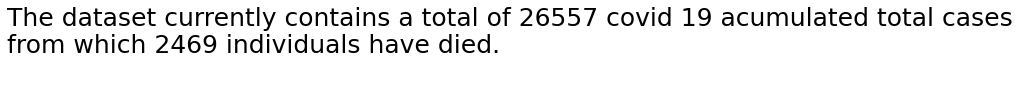

In [6]:
def get_totals(state):
    x=Deaths[Deaths.Estado == state]
    x=x.set_index('Estado')
    x=x.transpose()
    x.columns = ['Deaths']
    x['Death Rate']=x['Deaths'].diff()
    
    y=Confirmed[Confirmed.Estado == state]
    y=y.set_index('Estado')
    y=y.transpose()
    y.columns = ['Confirmed']
    y['Infection Rate']=y['Confirmed'].diff()
    
    data = y.join(x, how='inner')
    data = data.reset_index()
    data=data.rename(columns = {'index':'Date'})
    data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
    data['Infection Rate Avg'] = data['Infection Rate'].rolling(7).mean()
    data['Death Rate Avg'] = data['Death Rate'].rolling(7).mean()
    
    return data

st= get_totals(state)

fig, ax = plt.subplots(figsize=(3,1))
ax.text(0.0, 1.0, 'The dataset currently contains a total of {} covid 19 acumulated total cases'.format(st['Confirmed'].iloc[-1]), dict(size=25))
ax.text(0.0, 0.5, 'from which {} individuals have died.'.format(st['Deaths'].iloc[-1]), dict(size=25))
ax.axis('off')
plt.show()

Covid 19, originated in China in December, 2019 and caused by the SARS-CoV-2 virus, in less than a month it had been already been classified as a "Public Health Emergency of International Concern". To date, there are close to 170 million people with confirmed infection and has caused around 3.5 million deaths worldwide.

## Mexico City

The first case detected in our country occurred on February 27, 2020 at the National Institute of Respiratory Diseases, in Mexico City, in a patient with a history of having traveled to Italy; the first death occurred on March 18, 2020 at the National Institute of Respiratory Diseases, in Mexico City, in a patient with a history of having traveled to Italy.

The first death occurred on March 18. By March 24, with 475 confirmed cases, a Phase 2 "sanitary contingency" was decreed, with stricter measures of social distancing, confinement and work restriction. 

The spread of the disease has so far covered all the states of the Republic, with the highest rate of cases in Mexico City, Baja California and Sinaloa.

In [7]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from collections import OrderedDict
import folium
from folium.plugins import MarkerCluster,HeatMap
import math

df = pd.read_csv('C:/Users/Propietario/Desktop/Jupyter/Proyectos/Datasets/CDMX_Cases.csv')
pd.set_option('display.max_columns', None)
df.head()

id fecha_actualizacion id_registro          origen   sector  \
0   0          2021-01-25      0c2897           USMER      SSA   
1   1          2021-01-25      15b8ee  FUERA DE USMER  PRIVADA   
2   2          2021-01-25      0a87ea  FUERA DE USMER     IMSS   
3   3          2021-01-25      1dc972  FUERA DE USMER   ISSSTE   
4   4          2021-01-25      32d267  FUERA DE USMER      SSA   

         entidad_um    sexo       entidad_nac       entidad_res  \
0  CIUDAD DE MÉXICO  HOMBRE  CIUDAD DE MÉXICO  CIUDAD DE MÉXICO   
1  CIUDAD DE MÉXICO   MUJER  CIUDAD DE MÉXICO  CIUDAD DE MÉXICO   
2  CIUDAD DE MÉXICO  HOMBRE  CIUDAD DE MÉXICO  CIUDAD DE MÉXICO   
3  CIUDAD DE MÉXICO   MUJER  CIUDAD DE MÉXICO  CIUDAD DE MÉXICO   
4  CIUDAD DE MÉXICO  HOMBRE  CIUDAD DE MÉXICO  CIUDAD DE MÉXICO   

       municipio_res  tipo_paciente fecha_ingreso fecha_sintomas   fecha_def  \
0         Iztapalapa  HOSPITALIZADO    2020-04-29     2020-04-25         NaN   
1  Gustavo A. Madero    AMBULATORIO    2020-05-22     2020-05-18         NaN   
2       Azcapotzalco  HOSPITALIZADO    2020-05-06     2020-05-06  2020-05-06   
3  Gustavo A. Madero    AMBULATORIO    2020-06-03     2020-05-29         NaN   
4         Cuauhtémoc  HOSPITALIZADO    2020-05-05     2020-04-24         NaN   

    intubado neumonia  edad nacionalidad   embarazo habla_lengua_indi  \
0         NO       SI    53     MEXICANA  NO APLICA                NO   
1  NO APLICA       NO    39     MEXICANA         NO                NO   
2         NO       NO    60     MEXICANA  NO APLICA                NO   
3  NO APLICA       NO    40     MEXICANA         NO                NO   
4         NO       SI    59     MEXICANA  NO APLICA                NO   

    diabetes       epoc       asma   inmusupr hipertension   otra_com  \
0  SE IGNORA  SE IGNORA  SE IGNORA  SE IGNORA    SE IGNORA  SE IGNORA   
1         NO         NO         NO         NO           NO         SI   
2         NO         NO         NO         NO           NO         NO   
3         NO         NO         NO         NO           NO         NO   
4         SI         NO         NO         NO           SI         NO   

  cardiovascular   obesidad renal_cronica tabaquismo        otro_caso  \
0      SE IGNORA  SE IGNORA     SE IGNORA  SE IGNORA               SI   
1             NO         NO            NO         NO               SI   
2             NO         NO            NO         NO  NO ESPECIFICADO   
3             NO         SI            NO         NO               NO   
4             NO         SI            NO         NO               SI   

          migrante pais_nacionalidad pais_origen        uci rango_edad  \
0  NO ESPECIFICADO            México   NO APLICA         NO      51-60   
1  NO ESPECIFICADO            México   NO APLICA  NO APLICA      31-40   
2  NO ESPECIFICADO            México   NO APLICA         NO      51-60   
3  NO ESPECIFICADO            México   NO APLICA  NO APLICA      31-40   
4  NO ESPECIFICADO            México   NO APLICA         SI      51-60   

   num_fallecidos  num_hospitalizados  indigena  resultado_lab  \
0             NaN                 1.0         2             97   
1             NaN                 NaN         2              4   
2             1.0                 1.0         2             97   
3             NaN                 NaN         2             97   
4             NaN                 1.0         2              4   

   clasificacion_final clas_final_escrita confirmados  sospechosos negativos  \
0                    6        sospechosos         NaN  sospechosos       NaN   
1                    6        sospechosos         NaN  sospechosos       NaN   
2                    6        sospechosos         NaN  sospechosos       NaN   
3                    6        sospechosos         NaN  sospechosos       NaN   
4                    6        sospechosos         NaN  sospechosos       NaN   

   toma_muestra_lab  toma_muestra_antigeno  resultado_antigeno  
0                

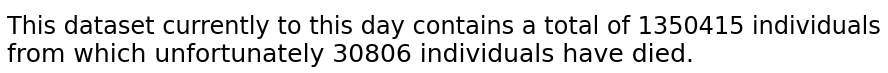

In [8]:
fig, ax = plt.subplots(figsize=(2,1))
ax.text(0.0, .5, 'This dataset currently to this day contains a total of {} individuals'.format(len(df)), dict(size=24))
ax.text(0.0, 0.0, 'from which unfortunately {} individuals have died.'.format(len(df.loc[(df['fecha_def'] != np.nan) & (df.fecha_def.notnull())])), dict(size=25))
ax.axis('off')
plt.show()

### Confirmed Cases and Deaths Infographics

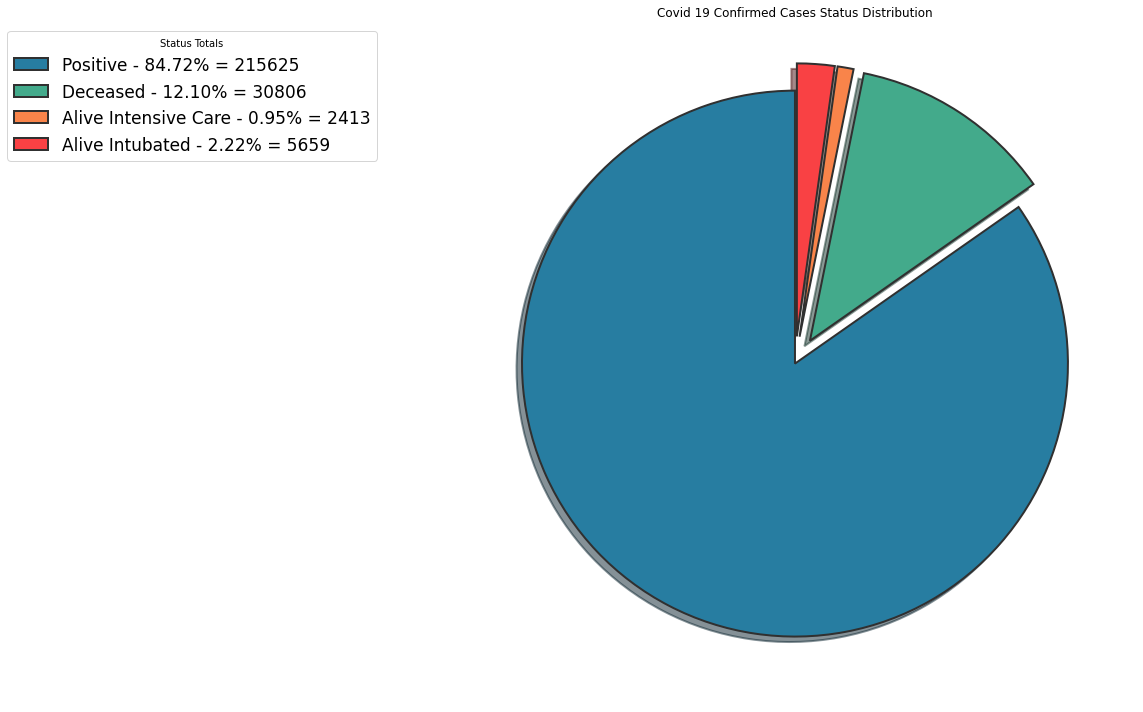

In [9]:
df['fecha_deff']=df['fecha_def']
z=pd.Series(df['fecha_deff'])
z.fillna('9999-99-99', inplace=True)
df['fecha_deff']=z

positives= df.loc[df['resultado_lab']==1]
deaths= df.loc[(df['fecha_deff']!='9999-99-99') & (df['fecha_deff'].notnull())]
intubated= df.loc[(df['intubado']== 'SI') & ((df['fecha_deff']!='9999-99-99') | (df['fecha_deff'].isnull())) & (df['resultado_lab']==1)] 
uci= df.loc[((df['fecha_deff']!='9999-99-99') | (df['fecha_deff'].isnull())) & (df['uci']== 'SI') & (df['intubado']== 'SI')]
c_positives=len(positives)
c_deaths=len(deaths)
c_intubated=len(intubated)
c_uci=len(uci)

colors = ['#277da1', '#43aa8b', '#f9844a', '#f94144', '#577590', '#90be6d', '#f8961e', '#4d908e', '#f9c74f', '#f3722c', '#43aa8b', '#f9844a', '#f94144', '#90be6d']

sizes = np.array([c_positives-c_deaths-c_intubated-c_uci, c_deaths, c_uci, c_intubated])

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title('Covid 19 Confirmed Cases Status Distribution')
patches, texts = ax1.pie(sizes,colors=colors, startangle=90, shadow=True, explode=(0.0,0.1,0.1,0.1),
                         wedgeprops={'linewidth': 2,"edgecolor":"#303030", 'linestyle': 'solid', 'antialiased': True})

percent = 100.*sizes/sizes.sum()
tags = ['Positive', 'Deceased', 'Alive Intensive Care', 'Alive Intubated']
labels = ['{0} - {1:0.2f}% = {2:0.0f}'.format(tags[x],percent[x],sizes[x]) for x in range(len(tags))]

ax1.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=17, title="Status Totals")
fig.tight_layout()

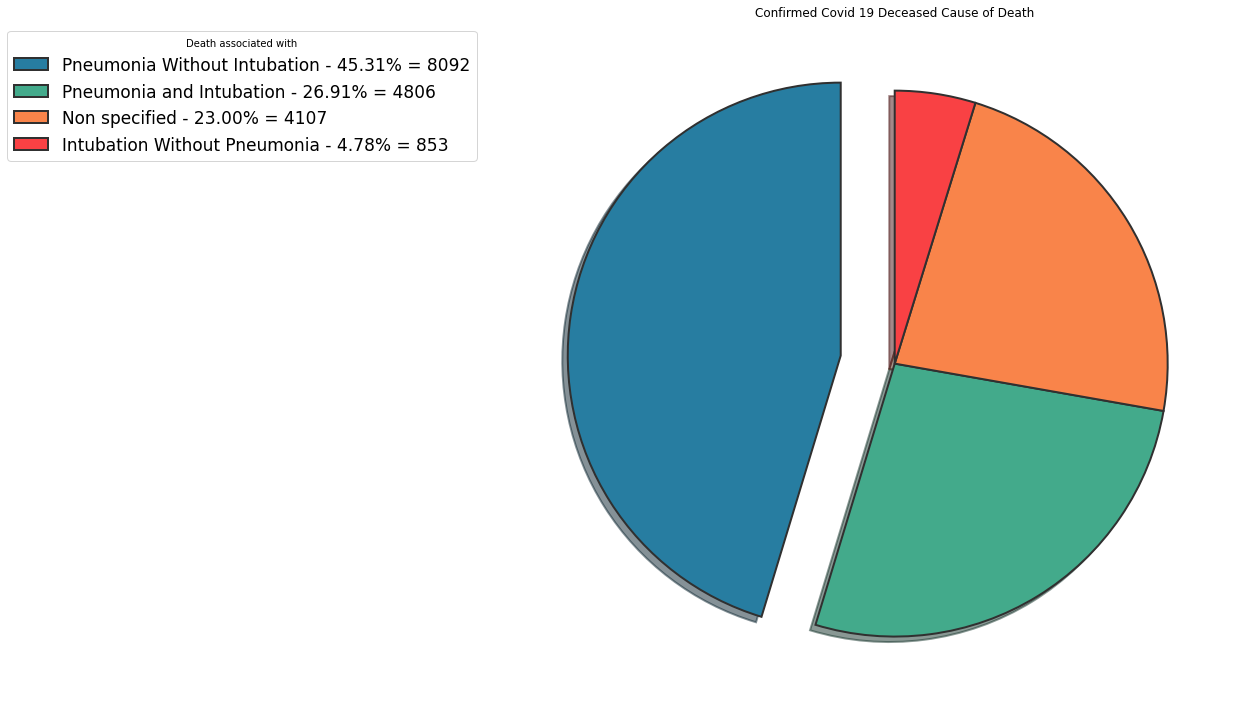

In [10]:
na = len(df.loc[(df['resultado_lab'] == 1) & (df['neumonia'] != 'SI') & (df['intubado'] != 'SI') & (df['fecha_deff'] != '9999-99-99')])
nia = len(df.loc[(df['resultado_lab'] == 1) & (df['intubado'] == 'SI') & (df['neumonia'] == 'SI') & (df['fecha_deff'] != '9999-99-99')])
ia = len(df.loc[(df['resultado_lab'] == 1) & (df['intubado'] == 'SI') & (df['neumonia'] != 'SI') & (df['fecha_deff'] != '9999-99-99') ])
n = len(df.loc[(df['resultado_lab'] == 1) & (df['neumonia'] == 'SI') & (df['intubado'] != 'SI') & (df['fecha_deff'] != '9999-99-99')])
d = {'Non specified':na,
        'Pneumonia and Intubation':nia,
        'Intubation Without Pneumonia':ia,
        'Pneumonia Without Intubation':n}
d = OrderedDict(sorted(d.items(), key=lambda kv: kv[1], reverse=True))
tags = list(d.keys())
sizes = np.array(list(d.values()))

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title('Confirmed Covid 19 Deceased Cause of Death')
patches, texts = ax1.pie(sizes,colors=colors, startangle=90, shadow=True, explode=(0.2,0,0,0.0),
                         wedgeprops={'linewidth': 2,"edgecolor":"#303030", 'linestyle': 'solid', 'antialiased': True})

labels = ['{0} - {1:.2f}% = {2}'.format(i,100*j/sum(sizes),j) for i,j in zip(list(tags), sizes)]
sort_legend = False
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, sizes),
                                          key=lambda x: x[2],
                                          reverse=True))


ax1.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=17, title="Death associated with")
fig.tight_layout()

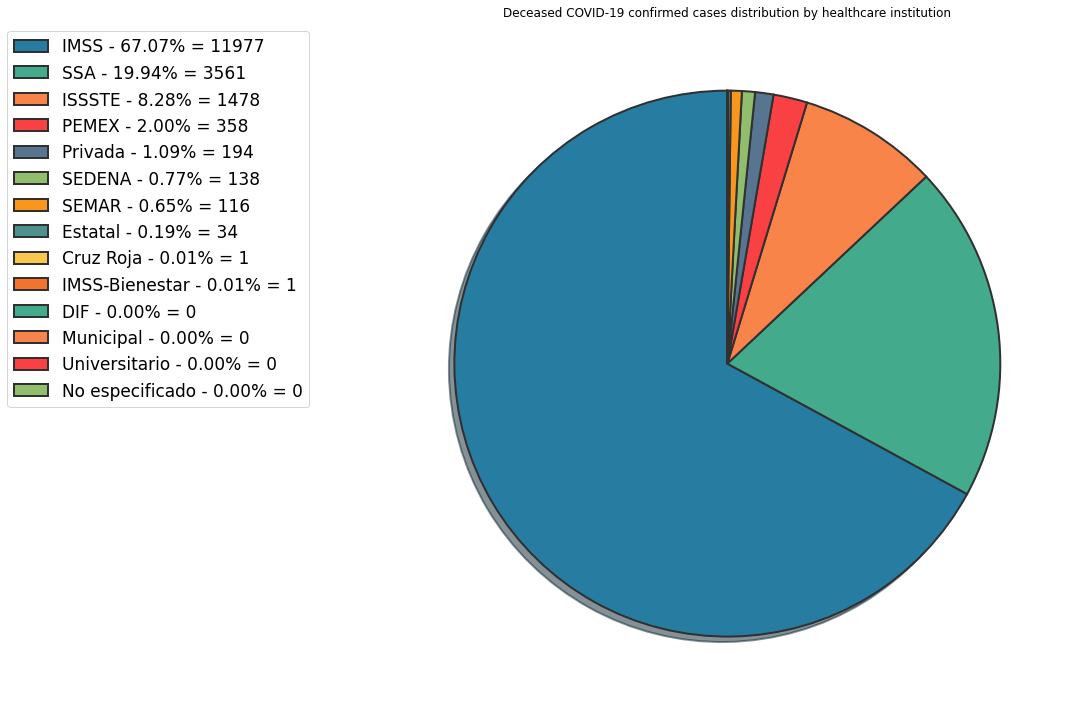

In [11]:
c={'Clave':[1,2,3,4,5,6,7,8,9,10,11,12,13,99],
   'Descripcion': ['Cruz Roja','DIF','Estatal','IMSS', 'IMSS-Bienestar','ISSSTE','Municipal','PEMEX','Privada','SEDENA','SEMAR','SSA','Universitario','No especificado']}
df_sector=pd.DataFrame(c)

df['sector'].replace('CRUZ ROJA', 1, inplace=True)
df['sector'].replace('DIF', 2, inplace=True)
df['sector'].replace('ESTATAL', 3, inplace=True)
df['sector'].replace('IMSS', 4, inplace=True)
df['sector'].replace('IMSS-BIENESTAR', 5, inplace=True)
df['sector'].replace('ISSSTE', 6, inplace=True)
df['sector'].replace('MUNICIPAL', 7, inplace=True)
df['sector'].replace('PEMEX', 8, inplace=True)
df['sector'].replace('PRIVADA', 9, inplace=True)
df['sector'].replace('SEDEMA', 10, inplace=True)
df['sector'].replace('SEMAR', 11, inplace=True)
df['sector'].replace('SSA', 12, inplace=True)
df['sector'].replace('UNIVERSITARIO', 13, inplace=True)

#colors = ['#2C699A', '#EFEA5A', '#16DB93', '#F29E4C', '#63ba00', '#05b08e', '#128ba6', '#5f0da6', '#b30bb0', '#c41484', '#a1183d', '#3859eb', '#4da1bf', '#6bcfb6']
df_sector['Total'] = [len(df.loc[(df['sector'] == x) & 
                                 (df['fecha_deff'] != '9999-99-99') & 
                                 (df['resultado_lab'] == 1)]) for x in list(df_sector['Clave'])]
df_sector = df_sector.sort_values('Total', ascending=False)

sizes = list(df_sector['Total'])

# Plot
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title('Deceased COVID-19 confirmed cases distribution by healthcare institution')
patches, texts = ax1.pie(sizes,colors=colors, startangle=90, shadow=True,
                         wedgeprops={'linewidth': 2,"edgecolor":"#303030", 'linestyle': 'solid', 'antialiased': True})

labels = ['{0} - {1:.2f}% = {2}'.format(i,100*j/sum(sizes),j) for i,j in zip(list(df_sector['Descripcion']), sizes)]
sort_legend = False
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, sizes),
                                          key=lambda x: x[2],
                                          reverse=True))


ax1.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=17)
fig.tight_layout()

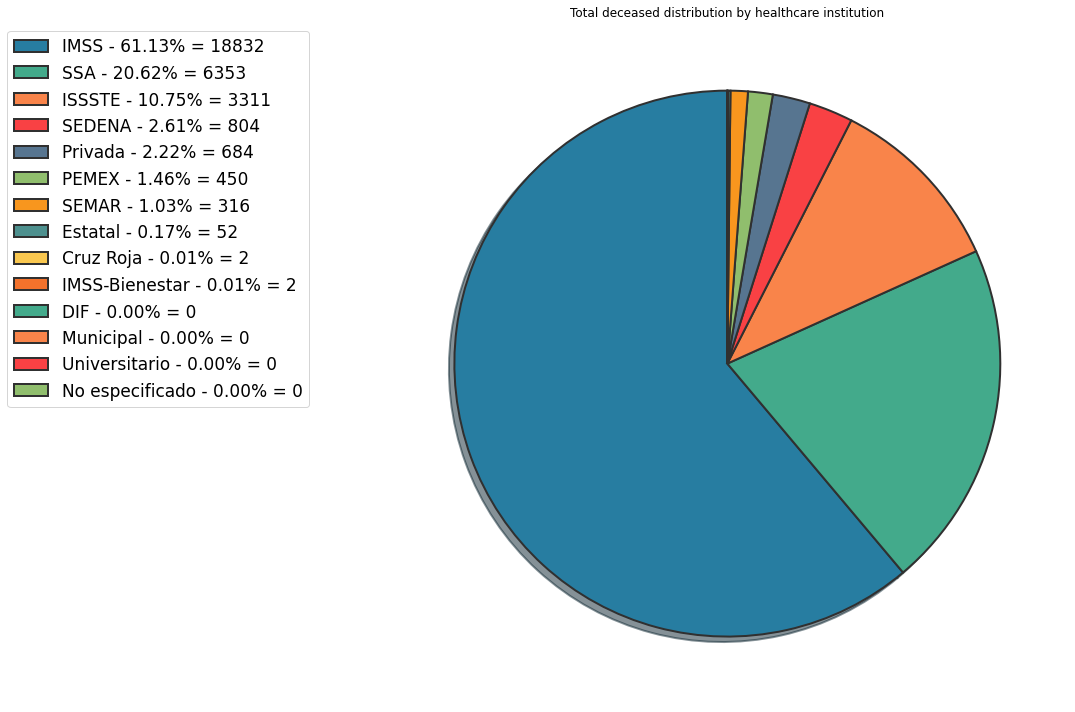

In [12]:
df_sector['Total'] = [len(df.loc[(df['sector'] == x) & (df['fecha_deff'] != '9999-99-99') & (df.fecha_deff.notnull())]) for x in list(df_sector['Clave'])]
df_sector = df_sector.sort_values('Total', ascending=False)

sizes = list(df_sector['Total'])

# Plot
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title('Total deceased distribution by healthcare institution')
patches, texts = ax1.pie(sizes,colors=colors, startangle=90, shadow=True,
                         wedgeprops={'linewidth': 2,"edgecolor":"#303030", 'linestyle': 'solid', 'antialiased': True})

labels = ['{0} - {1:.2f}% = {2}'.format(i,100*j/sum(sizes),j) for i,j in zip(list(df_sector['Descripcion']), sizes)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, sizes),
                                          key=lambda x: x[2],
                                          reverse=True))


ax1.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=17)
fig.tight_layout()

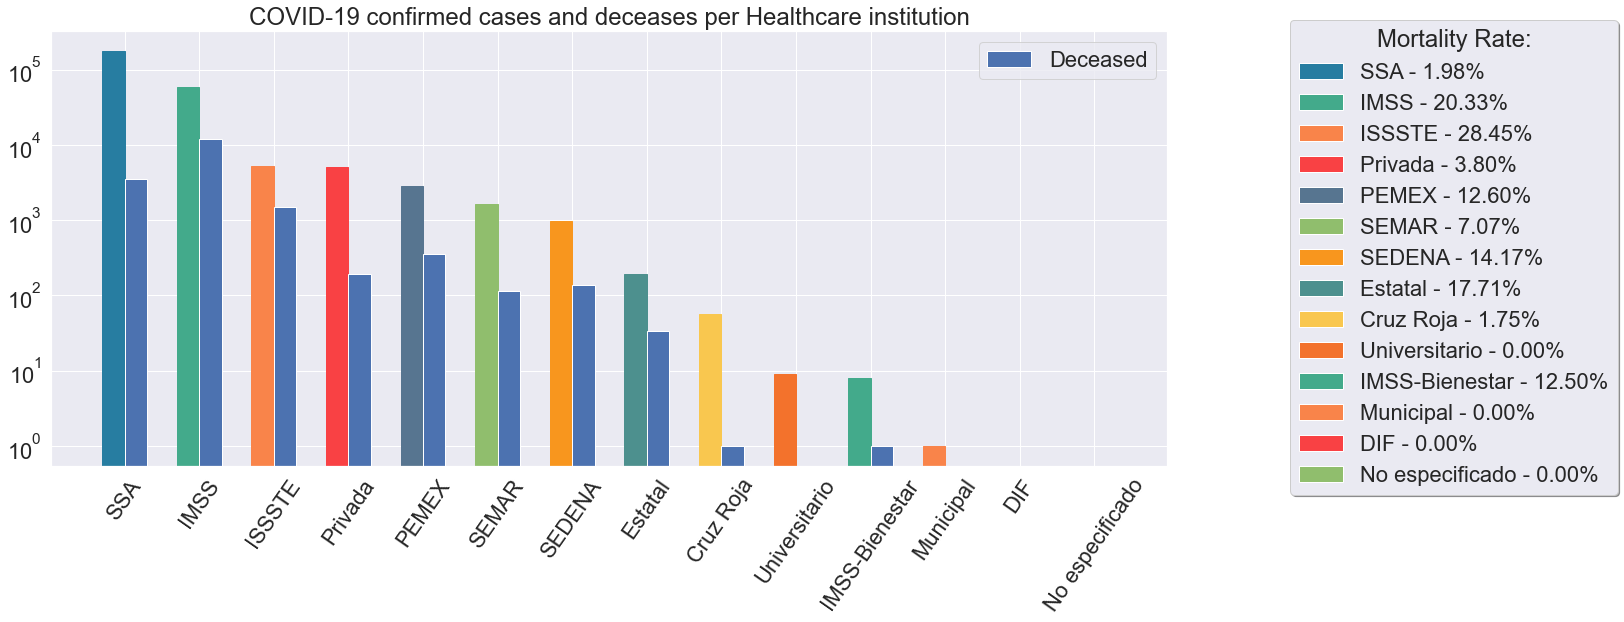

In [13]:
df_sector['TOTAL_M'] = [len(df.loc[(df['sector'] == x) & (df['fecha_deff'] != '9999-99-99') & (df.fecha_deff.notnull())]) for x in list(df_sector['Clave'])]
df_sector['TOTAL_MP'] = [len(df.loc[(df['sector'] == x) & (df['fecha_deff'] != '9999-99-99') & (df.fecha_deff.notnull()) & (df['resultado_lab'] == 1)]) for x in list(df_sector['Clave'])]
df_sector['TOTAL_P'] = [len(df.loc[(df['sector'] == x) & (df['resultado_lab'] == 1)]) for x in list(df_sector['Clave'])]
df_sector['PP_PM'] = (100*df_sector['TOTAL_MP'])/df_sector['TOTAL_P']
df_sector = df_sector.sort_values('TOTAL_P', ascending=False)
df_sector = df_sector.fillna(0)
sns.set(font_scale = 2)
fig, ax1 = plt.subplots(figsize=(20,8))
ax1.set_title('COVID-19 confirmed cases and deceases per Healthcare institution')
x = np.arange(len(df_sector['Descripcion']))
w=0.3
total_p = ax1.bar(x, df_sector['TOTAL_P'], width=w, color='#CF1259', align='center')
for i, bar in enumerate(total_p):
    bar.set_color(colors[i])
total_mp = ax1.bar(x + w, df_sector['TOTAL_MP'], width=w, align='center')
legend2 = ax1.legend([total_mp],['Deceased'])
ax1.legend(handles=[matplotlib.patches.Patch(facecolor=colors[x], label='{0} - {1:0.2f}%'.format(list(df_sector['Descripcion'])[x],list(df_sector['PP_PM'])[x])) for x in range(len(df_sector['Descripcion']))], 
                     loc='best',bbox_to_anchor=(1.1, 1.05), fancybox=True, shadow=True, title="Mortality Rate:")
ax1.set_yscale('log')
plt.xticks(x + w /2, df_sector['Descripcion'], rotation=55)
plt.gca().add_artist(legend2)
plt.show()

### Hospiatalization

In [14]:
dths=df.loc[(df['fecha_deff']!='9999-99-99') & (df['fecha_deff'].notnull())]
conf=df.loc[(df['fecha_deff']=='9999-99-99') & (df['fecha_deff'].notnull())]
hosp=df.loc[(df['fecha_deff']=='9999-99-99') & (df['fecha_deff'].notnull()) & (df['tipo_paciente'] =='HOSPITALIZADO')]
amb=df.loc[(df['fecha_deff']=='9999-99-99') & (df['fecha_deff'].notnull()) & ((df['tipo_paciente'] =='AMBULATORIO'))]
conf_female=df.loc[(df['fecha_deff']=='9999-99-99') & (df['fecha_deff'].notnull()) & (df['sexo']=='HOMBRE')]
conf_male=df.loc[(df['fecha_deff']=='9999-99-99') & (df['fecha_deff'].notnull()) & (df['sexo']=='MUJER')]
dths_male= df.loc[(df['fecha_deff']!='9999-99-99') & (df['fecha_deff'].notnull()) & (df['sexo']=='HOMBRE')]
dths_female= df.loc[(df['fecha_deff']!='9999-99-99') & (df['fecha_deff'].notnull()) & (df['sexo']=='MUJER')]

In [15]:
d_count=dths['fecha_deff'].value_counts()
d=pd.DataFrame(d_count)
d.sort_index(inplace=True)
d= d.reset_index()
d.columns=['Fecha', 'Count']
hosp_count=hosp['fecha_ingreso'].value_counts()
h=pd.DataFrame(hosp_count)
h.sort_index(inplace=True)
h= h.reset_index()
h.columns=['Fecha', 'Count']
h['Acumulado'] = h['Count'].cumsum()
d['Acumulado'] = d['Count'].cumsum()
fig=go.Figure()
fig.add_trace(go.Scatter(name= 'Hosp', x=h['Fecha'], y= h['Acumulado']))
fig.add_trace(go.Scatter(name= 'Deaths', x=d['Fecha'], y= d['Acumulado']))

In [16]:
h['Count Avg']=h['Count'].rolling(8).mean()
d['Count Avg']=d['Count'].rolling(8).mean()
fig=go.Figure()
fig.add_trace(go.Scatter(name= 'Hospitalized', x=h['Fecha'], y= h['Count Avg']))
fig.add_trace(go.Scatter(name= 'Deaths', x=d['Fecha'], y= d['Count Avg']))

In [17]:
c_male_c= conf_male['edad'].value_counts()
c_male_vls=pd.DataFrame(c_male_c)
c_male_vls.sort_index(inplace=True)
c_male_vls= c_male_vls.reset_index()
c_male_vls.columns=['Age', 'Count']
c_male_vls['Gender']='Male'
c_female_c= conf_female['edad'].value_counts()
c_female_vls=pd.DataFrame(c_female_c)
c_female_vls.sort_index(inplace=True)
c_female_vls= c_female_vls.reset_index()
c_female_vls.columns=['Age', 'Count']
c_female_vls['Gender']='Female'
df_c_vls= c_male_vls.append(c_female_vls)

d_male_c= dths_male['edad'].value_counts()
d_male_vls=pd.DataFrame(d_male_c)
d_male_vls.sort_index(inplace=True)
d_male_vls= d_male_vls.reset_index()
d_male_vls.columns=['Age', 'Count']
d_male_vls['Gender']='Male'
d_female_c= dths_female['edad'].value_counts()
d_female_vls=pd.DataFrame(d_female_c)
d_female_vls.sort_index(inplace=True)
d_female_vls= d_female_vls.reset_index()
d_female_vls.columns=['Age', 'Count']
d_female_vls['Gender']='Female'
df_d_vls= d_male_vls.append(d_female_vls)

bins=list(range(0,120,5))
labels=['0-5', '6-10', '11-15', '16-20','21-25', '26-30', '31-35', 
        '36-40', '41-45', '46-50', '51-55', '56-60','61-65','66-70',
        '71-75','76-80','81-85','86-90','91-95','96-100', '101-105',
        '106-110','111-115']
hosp['binned'] = pd.cut(hosp['edad'], bins)
hosp['age_by_bin']= pd.cut(x=hosp['edad'], bins=bins, labels=labels)
hosp_c= hosp['age_by_bin'].value_counts()
hosp_vls=pd.DataFrame(hosp_c)
hosp_vls.sort_index(inplace=True)
hosp_vls= hosp_vls.reset_index()
hosp_vls.columns=['Age', 'Count']
hosp_vls['Type']='Hospitalzed'

amb['binned'] = pd.cut(amb['edad'], bins)
amb['age_by_bin']= pd.cut(x=amb['edad'], bins=bins, labels=labels)
amb_c= amb['age_by_bin'].value_counts()
amb_vls=pd.DataFrame(amb_c)
amb_vls.sort_index(inplace=True)
amb_vls= amb_vls.reset_index()
amb_vls.columns=['Age', 'Count']
amb_vls['Type']='Ambulatory'

type_vls= hosp_vls.append(amb_vls)

In [18]:
fig = px.bar(type_vls, x='Age', color='Type',
             y='Count',
             title="Type of Pacient",
             barmode='overlay', #other modes: group, overlay, relative 
             height=500
            )
fig.show()

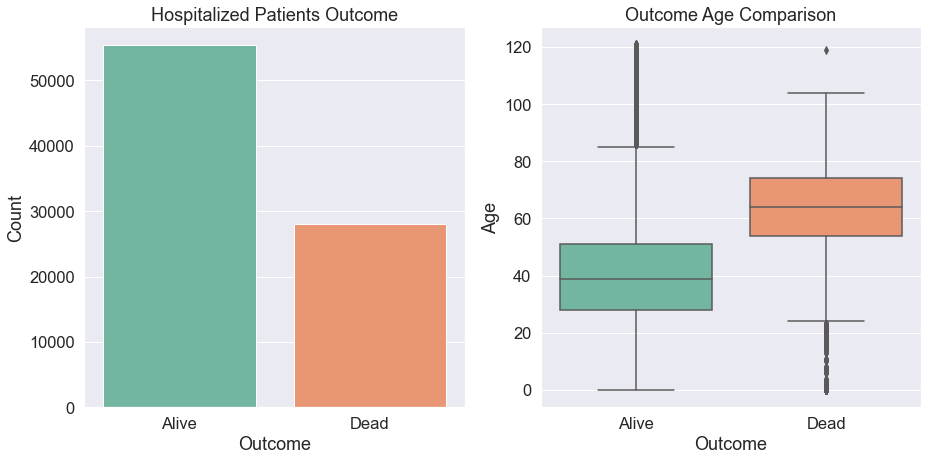

In [19]:
hosp_all=df.loc[(df['tipo_paciente'] =='HOSPITALIZADO')]
hosp_all['defuncion'] = 0
hosp_all.loc[df['fecha_deff'] != '9999-99-99', 'defuncion'] = 1
com= hosp_all['defuncion'].value_counts()
comp=pd.DataFrame(com)
comp= comp.reset_index()
comp.columns=['Outcome', 'Count']
comp.loc[0, 'Outcome']='Alive'
comp.loc[1, 'Outcome']='Dead'
df['defuncion'] = 'Alive'
df.loc[df['fecha_deff'] != '9999-99-99', 'defuncion'] = 'Dead'

sns.set(font_scale = 1.5)
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sns.barplot(x='Outcome', y='Count', data=comp, palette="Set2")
plt.title('Hospitalized Patients Outcome')
plt.subplot(1, 2, 2)
df['Outcome']=df['defuncion']
df['Age']=df['edad']
sns.boxplot(x='Outcome', y='Age', data=df, palette="Set2");
plt.title('Outcome Age Comparison');

One of the main reasons is that the hospital capacity has been exceeded during this health emergency of which there is a total of just 24,500 beds distributed in 92 hospitals in Mexico City to take care of Covid 19 patients in critic conditions. The hospital capacity has been in critical condition between May-October and December-February, exceeding 95% of the available beds.

The total number of cases with hospitalization on the left side, of which 33% unfortunately had a fatal outcome. Within this last quantity, the age difference between the outcomes stands out, since the average age of those who lived is 40 years while those who died is 60 years, therefore it can be said that the older the individual is, it is more likely to have a fatal outcome.

### Impact by Gender

In [20]:
fig = px.bar(df_c_vls, x='Age', color='Gender',
             y='Count',
             title="Covid 19 Confirmed Cases at Mexico City by Gender",
             barmode='overlay', #other modes: group, overlay, relative 
             height=600
            )

fig.show()

In [21]:
fig = px.bar(df_d_vls, x='Age', color='Gender',
             y='Count',
             title="Covid 19 Deaths at Mexico City by Gender",
             barmode='overlay', #other modes: group, overlay, relative 
             height=600
            )

fig.show()

Aparently infection cases age distribution behaves slightly similar on both genders with peak infection cases at 30 and 45 years old having a bias to males.  However a fatal outcome is way more probable for men, specially around 65 years old.

### Risk factors, comorbidities and mortality

<Figure size 504x360 with 0 Axes>

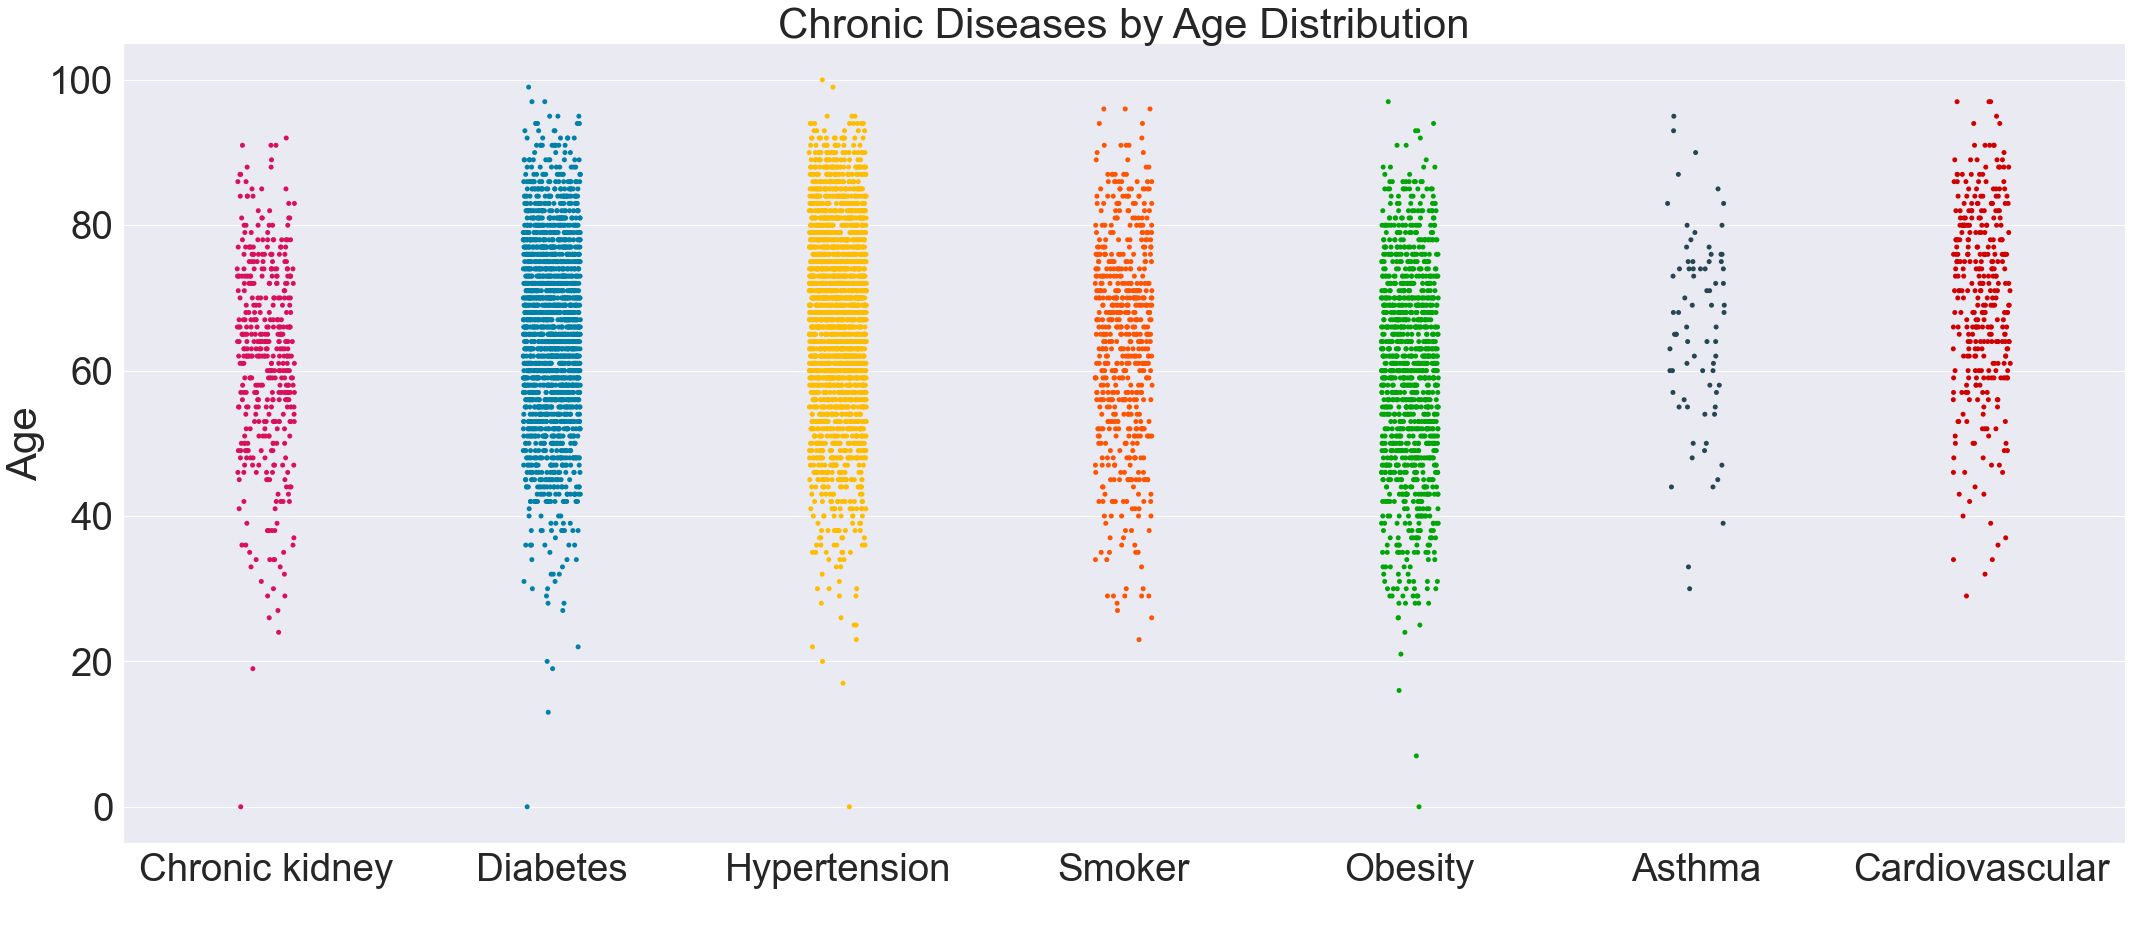

In [32]:
diseases=dths[['edad', 'diabetes', 'asma', 'hipertension', 'cardiovascular', 'obesidad', 'renal_cronica', 'tabaquismo']]
diseases.replace('SE IGNORA', 0, inplace=True)
diseases.replace('NO', 0, inplace=True)
diseases.replace('SI', 1, inplace=True)
diseases.columns=['Age', 'Diabetes', 'Asthma', 'Hypertension', 'Cardiovascular', 'Obesity', 'Chronic kidney', 'Smoker']
diseases['Asthma'].replace(1, 2, inplace=True)
diseases['Hypertension'].replace(1, 3, inplace=True)
diseases['Cardiovascular'].replace(1, 4, inplace=True)
diseases['Obesity'].replace(1, 5, inplace=True)
diseases['Chronic kidney'].replace(1, 6, inplace=True)
diseases['Smoker'].replace(1, 7, inplace=True)
dd = diseases.melt('Age', var_name='cols',  value_name='vals')
dd=dd.loc[(dd['vals']!=0)]
dd.columns=['Age', ' ', 'vals']

ddc=dd.copy()
ddn=ddc.sample(frac=0.2,random_state=0)
sns.set(font_scale = 3.5);
sns.set_palette(['#0081a7', '#264653', '#FFBD00', '#D00000', '#00A606', '#D81159', '#ff5400']);
plt.figure(figsize=(7, 5));
ax = sns.catplot(x=" ", y="Age", hue='vals', data=ddn, height=13, aspect=2.3, s = 5, label='Some').set(title='Chronic Diseases Distribution by Age');
ax._legend.remove();

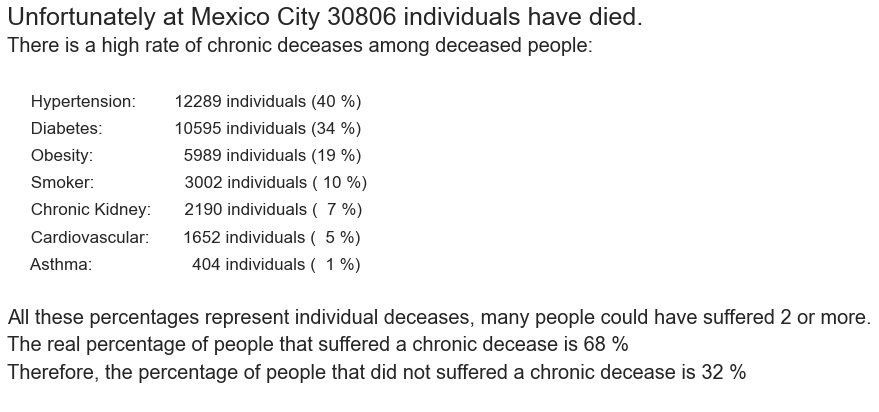

In [33]:
dt=df.loc[(df['fecha_deff']!='9999-99-99') & (df['fecha_deff'].notnull())]
diabetes=df.loc[(df['fecha_deff']!='9999-99-99') & (df['fecha_deff'].notnull()) & (df['diabetes']=='SI')]
asma=df.loc[(df['fecha_deff']!='9999-99-99') & (df['fecha_deff'].notnull()) & (df['asma']=='SI')]
hipert=df.loc[(df['fecha_deff']!='9999-99-99') & (df['fecha_deff'].notnull()) & (df['hipertension']=='SI')]
card=df.loc[(df['fecha_deff']!='9999-99-99') & (df['fecha_deff'].notnull()) & (df['cardiovascular']=='SI')]
obe=df.loc[(df['fecha_deff']!='9999-99-99') & (df['fecha_deff'].notnull()) & (df['obesidad']=='SI')]
smo=df.loc[(df['fecha_deff']!='9999-99-99') & (df['fecha_deff'].notnull()) & (df['tabaquismo']=='SI')]
renl=df.loc[(df['fecha_deff']!='9999-99-99') & (df['fecha_deff'].notnull()) & (df['renal_cronica']=='SI')]
diab_hipert=df.loc[(df['fecha_deff']!='9999-99-99') & (df['fecha_deff'].notnull()) & (df['diabetes']=='SI') & (df['hipertension']=='SI')]
totals=df.loc[(df['fecha_def'] != np.nan) & (df.fecha_def.notnull())]
zero=df.loc[(df['fecha_deff']!='9999-99-99') & (df['fecha_deff'].notnull()) & (df['cardiovascular']=='NO') & (df['diabetes']=='NO')& (df['asma']=='NO')& (df['hipertension']=='NO')& (df['obesidad']=='NO')& (df['tabaquismo']=='NO')& (df['renal_cronica']=='NO')& (df['epoc']=='NO')& (df['inmusupr']=='NO')& (df['otra_com']=='NO')]
chro=len(totals)-len(zero)

fig, ax = plt.subplots(figsize=(8,1))
ax.text(0.0, 7.0, 'Unfortunately at Mexico City {} individuals have died.'.format(len(totals)), dict(size=25))
ax.text(0.0, 6.5, 'There is a high rate of chronic deceases among deceased people:', dict(size=20))
ax.text(0.0, 5.5, '     Hypertension:        {} individuals ({} %)'.format(len(hipert), round((len(hipert)/len(totals)*100)), 2), dict(size=17))
ax.text(0.0, 5.0, '     Diabetes:               {} individuals ({} %)'.format(len(diabetes), round((len(diabetes)/len(totals)*100)), 2), dict(size=17))
ax.text(0.0, 4.5, '     Obesity:                   {} individuals ({} %)'.format(len(obe), round((len(obe)/len(totals)*100)), 2), dict(size=17))
ax.text(0.0, 4.0, '     Smoker:                   {} individuals ( {} %)'.format(len(smo), round((len(smo)/len(totals)*100)), 2), dict(size=17))
ax.text(0.0, 3.5, '     Chronic Kidney:       {} individuals (  {} %)'.format(len(renl), round((len(renl)/len(totals)*100)), 2), dict(size=17))
ax.text(0.0, 3.0, '     Cardiovascular:       {} individuals (  {} %)'.format(len(card), round((len(card)/len(totals)*100)), 2), dict(size=17))
ax.text(0.0, 2.5, '     Asthma:                     {} individuals (  {} %)'.format(len(asma), round((len(asma)/len(totals)*100)), 2), dict(size=17))
ax.text(0.0, 1.5, 'All these percentages represent individual deceases, many people could have suffered 2 or more.', dict(size=20))
ax.text(0.0, 1.0, 'The real percentage of people that suffered a chronic decease is {} %'.format(round(chro/len(totals)*100), 2), dict(size=20))
ax.text(0.0, 0.5, 'Therefore, the percentage of people that did not suffered a chronic decease is {} %'.format(round(len(zero)/len(totals)*100), 2), dict(size=20))
ax.axis('off')
plt.show()

Taking a sample of 20% of the total data, we can see the incidence of chronic degenerative diseases that have a negative impact on those individuals who were infected with covid19. Each point represents an individual case with a fatal outcome, of which the 3 with the highest incidence are: Diabetes, hypertension and obesity. Unfortunately, in Mexico a high percentage of these diseases prevail due to bad eating habits in our society / culture: ninth place in diabetes, first in hypertension and second in obesity in the world ranking.

### Confirmed Cases and Deaths by Sectors (Alcaldia)

In [34]:
mx_c= json.load(open('alcaldias.geojson', 'r'))
confirmed_cdmx=conf['municipio_res'].value_counts()
confirmed_cdmx=pd.DataFrame(confirmed_cdmx)
confirmed_cdmx.reset_index(inplace=True)
confirmed_cdmx.rename(columns = {'index':'Alcaldia', 'municipio_res':'Count'}, inplace = True)

deaths_cdmx=deaths['municipio_res'].value_counts()
deaths_cdmx=pd.DataFrame(deaths_cdmx)
deaths_cdmx.reset_index(inplace=True)
deaths_cdmx.rename(columns = {'index':'Alcaldia', 'municipio_res':'Count'}, inplace = True)

In [35]:
alcaldia_id_map={}
for feature in mx_c['features']:
    feature['id'] = feature['_id']
    alcaldia_id_map[feature['properties']['NOMGEO']]=feature['_id']
alcaldia_id_map

{'Tlalpan': 'auto-key-7429780027902524115',
 'TlÃ¡huac': 'auto-key-2036980934127505222',
 'Venustiano Carranza': 'auto-key--1866939550999246226',
 'CuauhtÃ©moc': 'auto-key--3280012380300712887',
 'Iztapalapa': 'auto-key-1294901331548964390',
 'Azcapotzalco': 'auto-key--6859368866396987561',
 'Benito JuÃ¡rez': 'auto-key-8934238601549741270',
 'Cuajimalpa de Morelos': 'auto-key--9048322781443683810',
 'Iztacalco': 'auto-key-422460999889819265',
 'Gustavo A. Madero': 'auto-key--3869264875956442447',
 'Miguel Hidalgo': 'auto-key-4911760509866541575',
 'La Magdalena Contreras': 'auto-key--9060627330283384203',
 'CoyoacÃ¡n': 'auto-key-904222990516758346',
 'Milpa Alta': 'auto-key-9025651286599012565',
 'Ã?lvaro ObregÃ³n': 'auto-key--1636713005818427720',
 'Xochimilco': 'auto-key-7500182090665101424'}

In [36]:
alcaldia_id_map2= {'Tlalpan': 'auto-key-7429780027902524115',
 'Tláhuac': 'auto-key-2036980934127505222',
 'Venustiano Carranza': 'auto-key--1866939550999246226',
 'Cuauhtémoc': 'auto-key--3280012380300712887',
 'Iztapalapa': 'auto-key-1294901331548964390',
 'Azcapotzalco': 'auto-key--6859368866396987561',
 'Benito Juárez': 'auto-key-8934238601549741270',
 'Cuajimalpa de Morelos': 'auto-key--9048322781443683810',
 'Iztacalco': 'auto-key-422460999889819265',
 'Gustavo A. Madero': 'auto-key--3869264875956442447',
 'Miguel Hidalgo': 'auto-key-4911760509866541575',
 'La Magdalena Contreras': 'auto-key--9060627330283384203',
 'Coyoacán': 'auto-key-904222990516758346',
 'Milpa Alta': 'auto-key-9025651286599012565',
 'Álvaro Obregón': 'auto-key--1636713005818427720',
 'Xochimilco': 'auto-key-7500182090665101424'}

deaths_cdmx['Id']= deaths_cdmx['Alcaldia']
deaths_cdmx['Id']= deaths_cdmx['Id'].apply(lambda x:alcaldia_id_map2[x])

fig= px.choropleth_mapbox(deaths_cdmx, 
                          locations='Id', 
                          geojson=mx_c, 
                          color='Count', 
                          hover_name='Alcaldia', 
                          mapbox_style= 'carto-positron', 
                          center={'lat': 19.3 , 'lon':-99.165}, 
                          zoom=8.7, 
                          opacity=0.7, title='Death Cases Distribution by Alcaldia',
                          width=550,
                          height=600)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

In [37]:
confirmed_cdmx['Id']= confirmed_cdmx['Alcaldia']
confirmed_cdmx['Id']= confirmed_cdmx['Id'].apply(lambda x:alcaldia_id_map2[x])

fig2= px.choropleth_mapbox(confirmed_cdmx, 
                          locations='Id', 
                          geojson=mx_c, 
                          color='Count', 
                          hover_name='Alcaldia', 
                          mapbox_style= 'carto-positron', 
                          center={'lat': 19.3 , 'lon':-99.165}, 
                          zoom=8.7, 
                          opacity=0.7, title='Confirmed Cases Distribution by Alcaldia',
                          width=550,
                          height=600)
fig2.update_geos(fitbounds='locations', visible=False)
fig2.show()

## Conclussions and Recommendations

In Mexico we have a complex situation: First, because COVID-19 infections and deaths continue, but also because of the economic and social impact of the pandemic, as well as a certain confusion in the population regarding the maintenance of effective measures to fight the infection rate. To this day, Mexico has the 14th rank in comfirmed cases worldwide, however we also have the 4rd death toll rank.

Through the pandemic with the start of the quarantine at the end of March, a gradual increase has been observed with a slight decrease in August, however, by December confirmed cases increase due to the holidays due to reunions, family meeting and cultural / religious customs of this country, being in January when we have the maximum peak of positive cases.

The average age of patients in Mexico is Mexico is only 45 years old with a predominance (58%) of the male gender. Of the confirmed active cases, 39.8% have had to be hospitalized and 5% are reported as critically ill. in critical condition. The trend of hospitalization and mortality increases with age. 

The world is experiencing a crisis unprecedented in this century. Pain from illness and loss will come, we will value commitment to care at the cost of personal risk, new medications and vaccines will appear and  we will overcome this phase, and we will learn much from it.

As John F. Kennedy aptly reminded us:

    "The word 'crisis' written in Chinese is composed of two characters.
    The first: Wei (危) represents risk, and the second: Chi (机) opportunity."